# Neo4j con Python

http://nicolewhite.github.io/neo4j-jupyter/hello-world.html

## py2neo

py2neo is one of Neo4j's Python drivers. It offers a fully-featured interface for interacting with your data in Neo4j.

http://py2neo.org/v3/#

In [1]:
import py2neo 
print(py2neo.__version__)

3.1.2


## Connect
Connect to Neo4j with the Graph class.

In [8]:
from py2neo import Graph

graph = Graph()

In [9]:
graph.delete_all()

## Nodes
Create nodes with the Node class. The first argument is the node's label. The remaining arguments are an arbitrary amount of node properties or key-value pairs.

In [10]:
from py2neo import Node

In [11]:
nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

graph.create(nicole | drew | mtdew | cokezero | coke | pepsi)

In [12]:
drew.update(city = 'NY', country = 'US')
graph.push(drew)

We have only one Nicole!

In [13]:
graph.merge(Node("Person", name="Nicole", age=24))

In [14]:
from scripts.vis import draw

options = {"Person": "name", "Drink": "name", "Manufacturer": "name"}
draw(graph, options)

## Relationships
Create relationships between nodes with the Relationship class.

In [15]:
from py2neo import Relationship

rel_nicole_cokezero = Relationship(nicole, "LIKES", cokezero)
rel_nicole_mtdew = Relationship(nicole, "LIKES", mtdew)
rel_drew_mtdew = Relationship(drew, "LIKES", mtdew)
rel_coke_cokezero = Relationship(coke, "MAKES", cokezero)
rel_pepsi_mtdew = Relationship(pepsi, "MAKES", mtdew)

graph.create(rel_nicole_cokezero | rel_nicole_mtdew | rel_drew_mtdew |  rel_coke_cokezero | rel_pepsi_mtdew)

draw(graph, options)

## Relationships with atributes

In [28]:
rel_drew_pepsi = Relationship(drew, "WORKS", pepsi, years = 5)

graph.create(rel_drew_pepsi)

## Cypher
Retrieve Cypher query results with Graph.cypher.execute.

In [16]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, person.city as City, drink.name AS drink
"""

data = graph.run(query)

for d in data:
    print(d)

('name': 'Nicole', 'City': None, 'drink': 'Coke Zero')
('name': 'Drew', 'City': 'NY', 'drink': 'Mountain Dew')
('name': 'Nicole', 'City': None, 'drink': 'Mountain Dew')


## Parameterized Cypher
Pass parameters to Cypher queries by passing additional key-value arguments to Graph.cypher.execute. Parameters in Cypher are named and are wrapped in curly braces.

In [17]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.run(query, name="Nicole")

for d in data:
    print(d)

('name': 'Nicole', 'avg_calories': 4500.0)


## ipython-cypher
ipython-cypher exposes %cypher magic in Jupyter. Install ipython-cypher with pip install ipython-cypher.

In [18]:
%load_ext cypher

## Cypher
%cypher is intended for one-line Cypher queries and %%cypher is intended for multi-line Cypher queries. Placing %%cypher above a Cypher query will display that query's results.

In [19]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Coke Zero,0
Nicole,Mountain Dew,9000
Drew,Mountain Dew,9000


## Pandas Data Frames
Cypher query results can be coerced to pandas data frames with the get_dataframe method. To assign Cypher query results to a variable, you need to use **%cypher** and separate lines with \ 

You'll first need to install pandas with pip install pandas.

In [20]:
results = %cypher MATCH (person:Person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Nicole,Coke Zero
1,Drew,Mountain Dew
2,Nicole,Mountain Dew


## NetworkX Graphs
Cypher query results can be coerced to NetworkX MultiDiGraphs, graphs that permit multiple edges between nodes, with the get_graph method

3 rows affected.


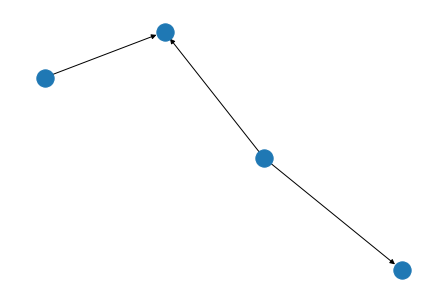

In [21]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [22]:
g.nodes(data=True)

NodeDataView({'2': {'name': 'Nicole', 'age': 24, 'labels': ['Person']}, '20': {'name': 'Coke Zero', 'calories': 0, 'labels': ['Drink']}, '23': {'name': 'Mountain Dew', 'calories': 9000, 'labels': ['Drink']}, '24': {'country': 'US', 'city': 'NY', 'name': 'Drew', 'age': 20, 'labels': ['Person']}})

In [23]:
nx.degree(g)

DiMultiDegreeView({'2': 2, '20': 1, '23': 2, '24': 1})

## igraph
Cypher query results can be imported into igraph with py2neo. You'll need to install igraph with pip install python-igraph. Query results should be returned as edgelists, as igraph has a method for building an igraph object from a list of tuples representing edges between nodes.

In [24]:
from py2neo import Graph as PGraph
from igraph import Graph as IGraph

neo4j = PGraph()

query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS source, drink.name AS target
"""

data = neo4j.run(query)
tups = []

for d in data:
    tups.append((d["source"], d["target"]))

In [25]:
from igraph import Graph

In [26]:
ig = IGraph.TupleList(tups)

ig

In [27]:
best = ig.vs.select(_degree = ig.maxdegree())["name"]
best

['Nicole', 'Mountain Dew']